# 多PDF文档RAG


在本教程中了解如何使用多个 PDF 创建 Retrieval-Augmented Generation （RAG） 模型。我们将提取相关信息并将其存储在矢量数据库中，并按以下方式进行索引：

- Chunk_ID
- Unique Document ID 唯一文档 ID
- Content 内容

如下图所示。然后，我们可以处理用户查询并使用信息来源生成相关响应。

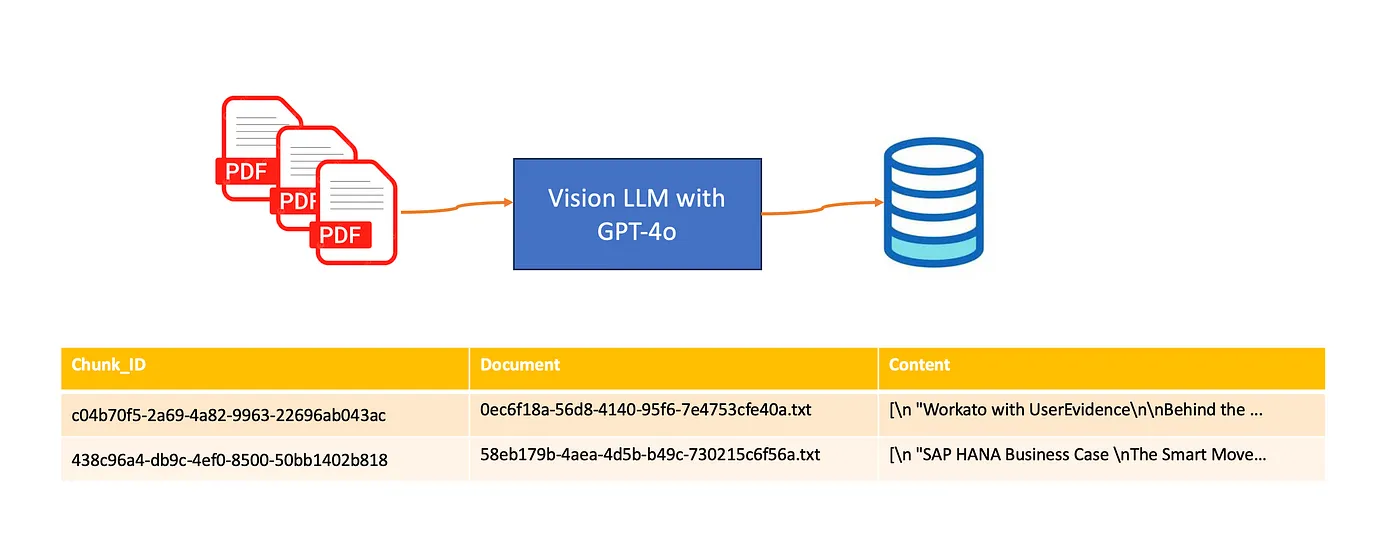

为了构建检索增强生成器 （RAG），我们首先将 PDF 页面转换为图像，然后由 GPT-4o（一种支持视觉的大型语言模型）进行处理以提取文本。因此，我们现在可以获得 PDF 信息的丰富而准确的表示形式，包括文本和图像，而不会丢失重要细节，例如图表、图形和其他可视化效果。

In [3]:
!pip install pypdfium2 backoff openai langchain_openai langchain langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00


In [4]:
from io import BytesIO
import pypdfium2 as pdfium
import backoff
import asyncio
import json
import os
import base64
import uuid
import pandas as pd
from PIL import Image
from IPython.display import Image, display

from openai import OpenAIError
from openai import AsyncOpenAI, OpenAI
from langchain_openai import ChatOpenAI

from langchain.text_splitter import CharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

配置OpenAI 的 GPT-4o 模型

In [ ]:
MODEL = "gpt-4o-2024-08-06"
baseurl = ""
apikey = ""

clienta = AsyncOpenAI(api_key=apikey,  base_url=baseurl)
os.environ["OPENAI_API_BASE"] = baseurl
os.environ["OPENAI_API_KEY"] = apikey

接下来，我们将定义一个用于图像到文本转换的函数，并集成backoff库来管理 API 速率限制并防止限制。

In [ ]:
@backoff.on_exception(backoff.expo, OpenAIError)
async def parse_page_with_gpt(base64_image: str) -> str:
    messages=[
        {
            "role": "system",
            "content": """

            You are a helpful assistant that extracts information from images into text.
            Do not answer with any additional explanations like "Sure, here is the extracted text"

            """
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Extract information from this document"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                        "detail": "auto"
                    },
                },
            ],
        }
    ]
    response = await clienta.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        max_tokens=4096,
    )
    return response.choices[0].message.content or ""

定义 PDF 页面转换为图像的函数，将它们输入到图像到文本的转换过程中以检索文本数据。

In [ ]:
async def document_analysis(filename: str) -> str:
    """
    Document Understanding

    Args:
        filename: pdf filename str
    """

    pdf = pdfium.PdfDocument(filename)
    images = []
    for i in range(len(pdf)):
        page = pdf[i]
        image = page.render(scale=4).to_pil()
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        img_byte = buffered.getvalue()
        img_base64 = base64.b64encode(img_byte).decode("utf-8")
        images.append(img_base64)

    text_of_pages = await asyncio.gather(*[parse_page_with_gpt(image) for image in images])

    results = []

    extracted_texts = [doc for doc in text_of_pages]

    for text in extracted_texts:
        cleaned_content_json = text.strip('```plaintext\n').strip('')
        results.append(cleaned_content_json)

    return results

 定义vector store 中管理文档的函数：display、add 和 deletion，因此我们最终可以得到这样的东西。

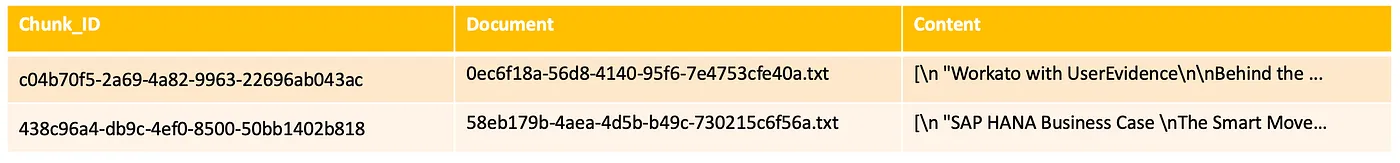

In [ ]:
# display documents in vstore
def show_vstore(store):
    vector_df = store_to_df(store)
    display(vector_df)

# convert vector store into dataframe
def store_to_df(store):
    v_dict = store.docstore._dict
    data_rows = []
    for k in v_dict.keys():
        doc_name = v_dict[k].metadata['source'].split('/')[-1]
        content = v_dict[k].page_content
        data_rows.append({"chunk_id": k, "document": doc_name, "content": content})
    vector_df = pd.DataFrame(data_rows)
    return vector_df

# add document to vector store
def add_to_vector_store(file, store):
    loader = TextLoader(file)
    documents = loader.load()

    chunk_size=1000
    chunk_overlap=500

    text_splitter = CharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len
    )
    texts = text_splitter.split_documents(documents)

    embeddings = OpenAIEmbeddings()
    extension = FAISS.from_documents(texts, embeddings)
    store.merge_from(extension)

# delete document from vector store
def delete_document(store, document):
    vector_df = store_to_df(store)
    chunk_lists = vector_df.loc[vector_df['document']==document]['chunk_id'].tolist()
    store.delete(chunk_lists)

使用空白文档占位符初始化矢量存储。这将使我们能够上传和存储我们选择的 PDF 文档

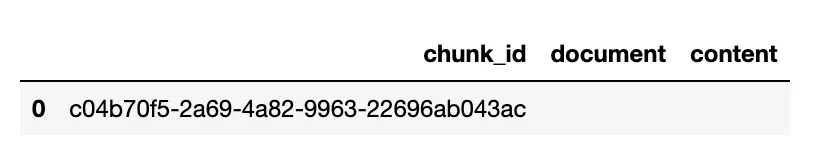

In [ ]:
# Create a place holder vector store
document = Document(
    page_content="",
    metadata={"source": ""},
)
documents = [document]
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(documents, embeddings)

添加第一个 PDF 文档。

In [ ]:
docs_list = await document_analysis("workato.pdf")

然后添加到 vector store 中。

In [ ]:
output_file_path = f"{uuid.uuid4()}.txt"

with open(output_file_path, 'w') as json_file:
    json.dump(docs_list, json_file, indent=2)

print(f"data has been written to {output_file_path}")

add_to_vector_store(output_file_path, vectorstore)

# Check if the file exists
if os.path.exists(output_file_path):

    # Delete the file
    os.remove(output_file_path)
    print(f"File {output_file_path} deleted successfully.")
else:
    print("File does not exist.")

添加第二个 PDF 文档。

In [ ]:
docs_list = await document_analysis("HANA Business Case.pdf")

然后添加到第二个文档的向量存储中。

In [ ]:
output_file_path = f"{uuid.uuid4()}.txt"

with open(output_file_path, 'w') as json_file:
    json.dump(docs_list, json_file, indent=2)

print(f"data has been written to {output_file_path}")

add_to_vector_store(output_file_path, vectorstore)

# Check if the file exists
if os.path.exists(output_file_path):

    # Delete the file
    os.remove(output_file_path)
    print(f"File {output_file_path} deleted successfully.")
else:
    print("File does not exist.")

查询vector store内容

In [ ]:
show_vstore(vectorstore)

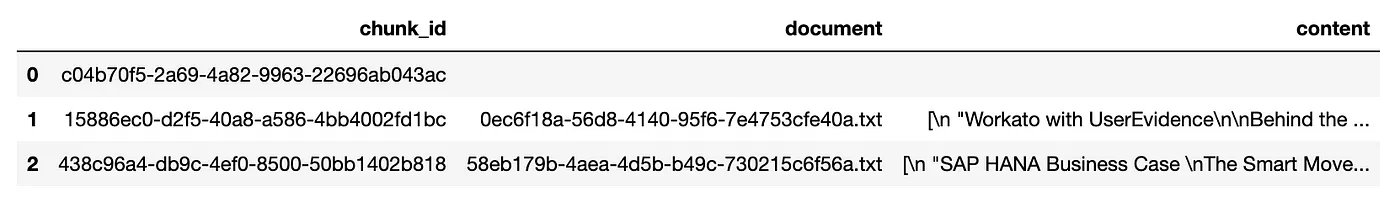

通过我们最近添加的内容（索引 1 和 2 的文档）和初始占位符（索引 0），我们现在可以从向量存储中查询和检索信息。

设置检索器和llm。

In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})
llm = ChatOpenAI(model_name="gpt-4o", temperature=0, streaming=True)

提出一个与第一个文档的上下文相关的问题。

In [ ]:
#RAG Chain
rag_prompt = PromptTemplate(
    template="""

    You are a helpful assistant tasked with performing document understanding. Do not answer with any additional explanations like "Sure, here is the extracted text"
    Always return in JSON with source of document.

    QUESTION: {question} \n
    CONTEXT: {context} \n
    Answer:

    """,
    input_variables=["question","context"],
)

rag_prompt_chain = rag_prompt | llm | StrOutputParser()

QUESTION = """

What are the companies in the Opportunity to Cash in SAP HANA context?

"""
CONTEXT = retriever.invoke(QUESTION)

result = rag_prompt_chain.invoke({"question": QUESTION, "context":CONTEXT})

print(result)

结果是正确的

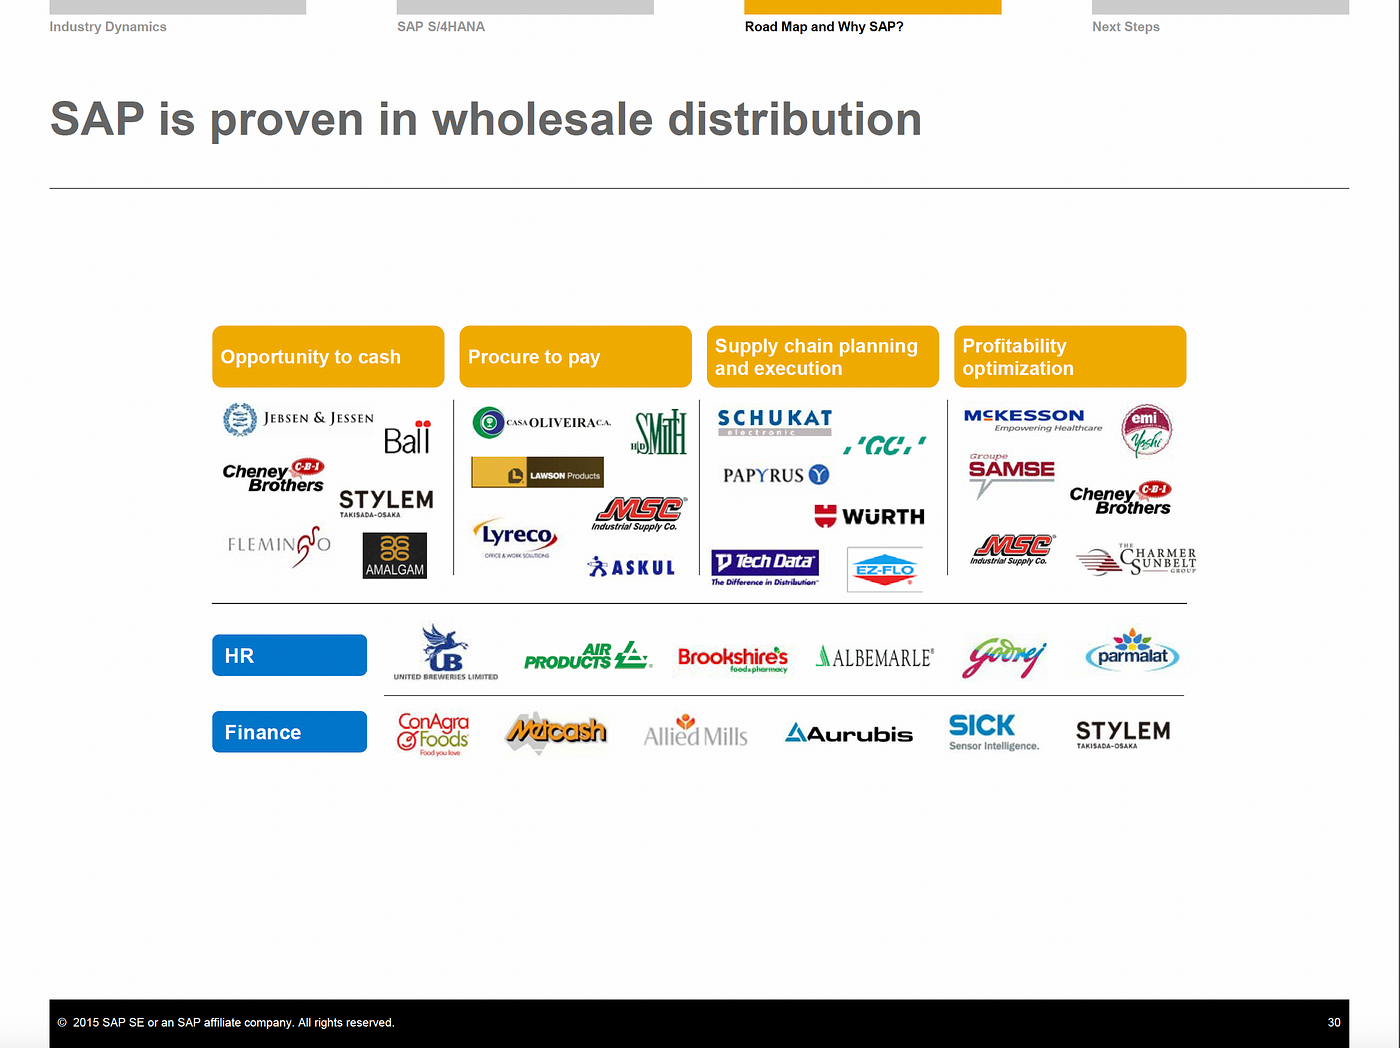

现在，让我们提出另一个与第二个文档相关的问题。

In [ ]:
#RAG Chain
rag_prompt = PromptTemplate(
    template="""

    You are a helpful assistant tasked with performing document understanding. Do not answer with any additional explanations like "Sure, here is the extracted text"
    Always return in JSON with source of document.

    QUESTION: {question} \n
    CONTEXT: {context} \n
    Answer:

    """,
    input_variables=["question","context"],
)

rag_prompt_chain = rag_prompt | llm | StrOutputParser()

QUESTION = """

In Workato context, what is the percentage of Strong Governance in Figure 4.1 ?

"""
CONTEXT = retriever.invoke(QUESTION)

result = rag_prompt_chain.invoke({"question": QUESTION, "context":CONTEXT})

print(result)

结果也是正确的。

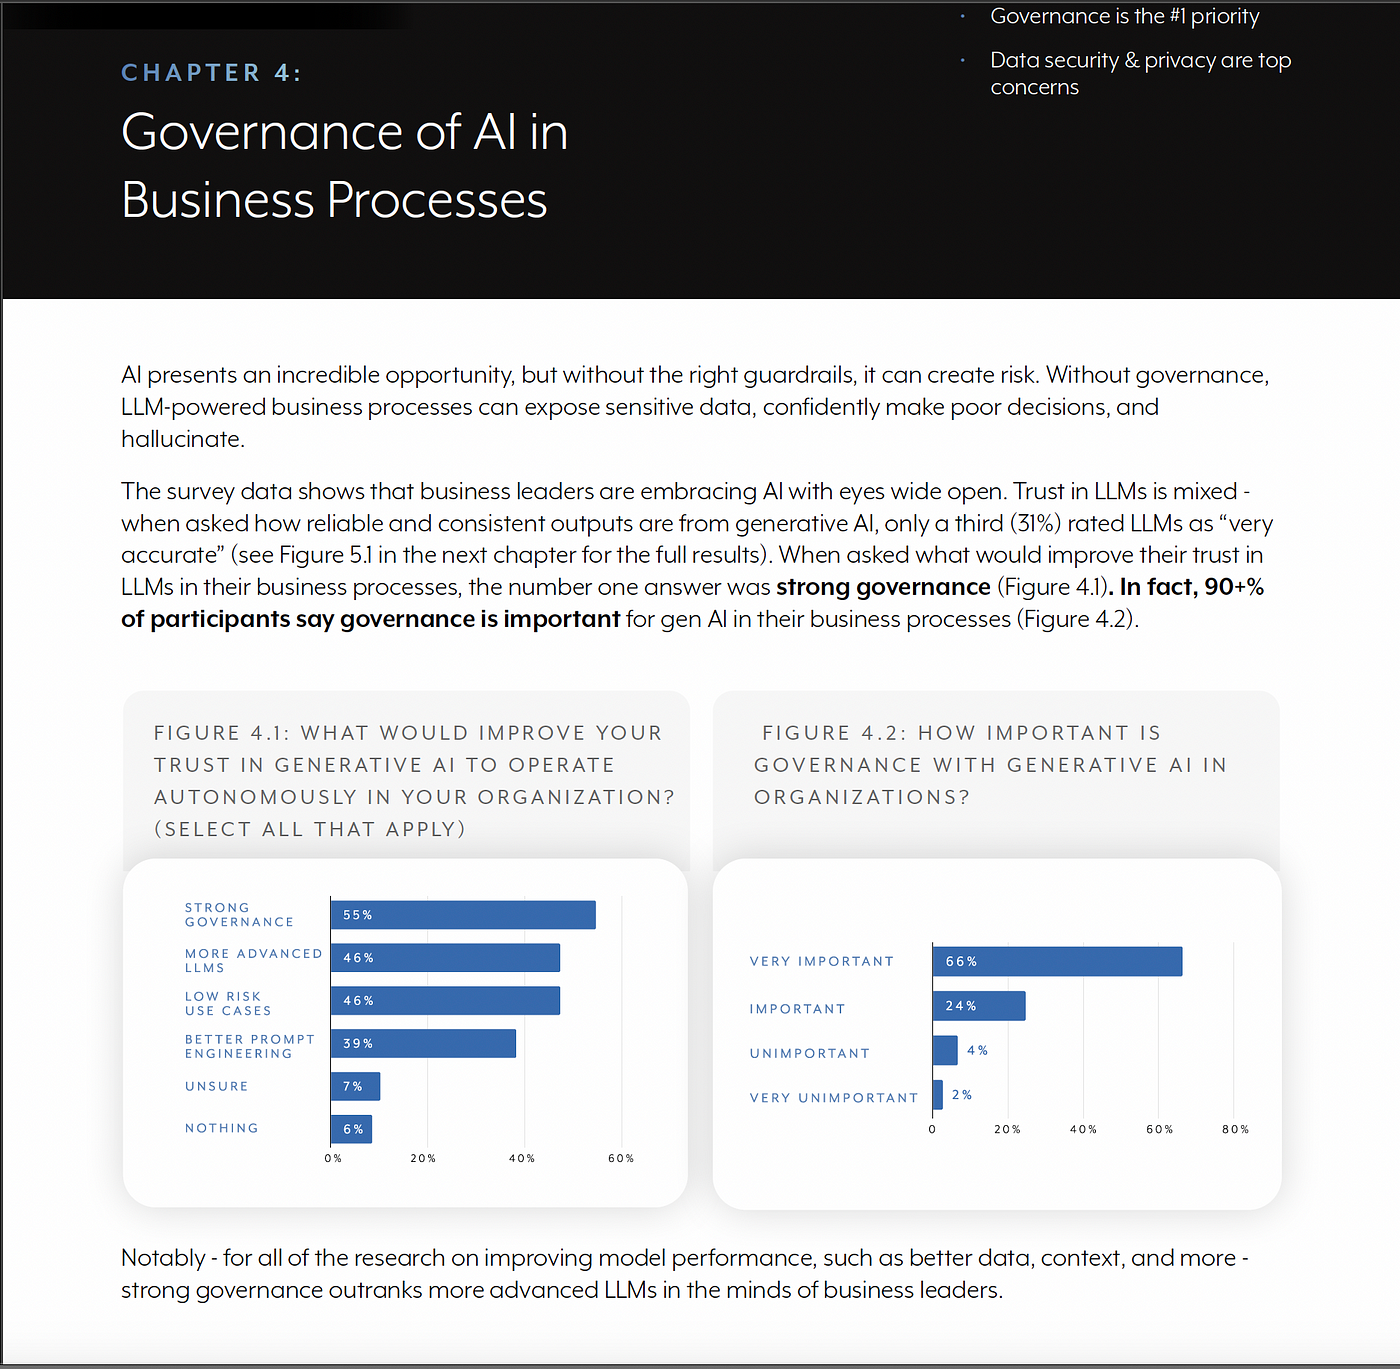